In [1]:
!conda init

/bin/bash: line 1: conda: command not found


In [1]:
from sklearn.manifold import MDS
from scipy.spatial.distance import squareform
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import torch
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
import geoopt  # For hyperbolic geometry operations


In [8]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots

def plot_3d_umap_embedding_plotly(hyperbolic_mapper, captions_np, le=None, 
                                 figsize=(1000, 800), show_legend=True, 
                                 point_size=5, opacity=0.7):
    """
    Create an interactive 3D scatter plot of UMAP embeddings using Plotly.
    
    Args:
        hyperbolic_mapper: Fitted UMAP model with embedding_ attribute
        captions_np: Array of string labels/captions
        le: Optional LabelEncoder (if None, will create mapping from captions_np)
        figsize: Figure size tuple (width, height) in pixels
        show_legend: Whether to show the legend
        point_size: Size of scatter plot points
        opacity: Opacity of points (0-1)
    
    Returns:
        plotly.graph_objects.Figure: Interactive 3D plot
    """
    # Get 3D embeddings
    embedding_3d = hyperbolic_mapper.embedding_  # shape (N, 3)
    print(f"Embedding shape: {embedding_3d.shape}")
    
    # Prepare labels and colors
    unique_labels_str = np.unique(captions_np)
    class_names = unique_labels_str.tolist()
    n_colors = len(class_names)
    
    # Create a DataFrame for easier handling
    df = pd.DataFrame({
        'x': embedding_3d[:, 0],
        'y': embedding_3d[:, 1], 
        'z': embedding_3d[:, 2],
        'label': captions_np,
        'point_id': range(len(embedding_3d))
    })
    
    # Use le.classes_ if provided, otherwise use class_names
    legend_class_names = le.classes_ if le is not None else class_names
    
    # Create color palette - using Plotly's qualitative colors for better distinction
    if n_colors <= 10:
        colors = px.colors.qualitative.Set1
    elif n_colors <= 24:
        colors = px.colors.qualitative.Dark24
    else:
        # For many classes, use a continuous colorscale
        colors = px.colors.sample_colorscale("rainbow", n_colors)
    
    # Ensure we have enough colors
    while len(colors) < n_colors:
        colors.extend(colors)
    
    # Create the 3D scatter plot
    fig = go.Figure()
    
    # Add traces for each class to enable legend control
    for i, class_name in enumerate(class_names):
        class_data = df[df['label'] == class_name]
        real_class = class_name if le is None else le.inverse_transform([class_name])[0]
        
        # Create hover text with detailed information
        hover_text = [
            f"<b>Label:</b> {label}<br>" +
            f"<b>Point ID:</b> {point_id}<br>" +
            f"<b>Coordinates:</b><br>" +
            f"  X: {x:.3f}<br>" +
            f"  Y: {y:.3f}<br>" +
            f"  Z: {z:.3f}<br>" +
            f"<b>Class:</b> {real_class}<br>" +
            f"<b>Count in class:</b> {len(class_data)}"
            for label, point_id, x, y, z in zip(
                class_data['label'], class_data['point_id'], 
                class_data['x'], class_data['y'], class_data['z']
            )
        ]
        
        fig.add_trace(go.Scatter3d(
            x=class_data['x'],
            y=class_data['y'], 
            z=class_data['z'],
            mode='markers',
            name=real_class,
            text=hover_text,
            hovertemplate='%{text}<extra></extra>',
            marker=dict(
                size=point_size,
                color=colors[i % len(colors)],
                opacity=opacity,
                line=dict(width=0.5, color='DarkSlateGrey')
            ),
            showlegend=show_legend
        ))
    
    # Update layout for better visualization
    fig.update_layout(
        title={
            'text': f'Interactive 3D UMAP Embedding Visualization<br><sub>Colored by Caption Categories ({n_colors} classes, {len(embedding_3d)} points)</sub>',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16}
        },
        width=figsize[0],
        height=figsize[1],
        scene=dict(
            xaxis_title='UMAP Dimension 1',
            yaxis_title='UMAP Dimension 2', 
            zaxis_title='UMAP Dimension 3',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)  # Good default viewing angle
            ),
            bgcolor='rgba(0,0,0,0)',  # Transparent background
            xaxis=dict(
                backgroundcolor="rgba(0,0,0,0)",
                gridcolor="lightgray",
                showbackground=True,
                zerolinecolor="lightgray"
            ),
            yaxis=dict(
                backgroundcolor="rgba(0,0,0,0)",
                gridcolor="lightgray", 
                showbackground=True,
                zerolinecolor="lightgray"
            ),
            zaxis=dict(
                backgroundcolor="rgba(0,0,0,0)",
                gridcolor="lightgray",
                showbackground=True, 
                zerolinecolor="lightgray"
            )
        ),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left", 
            x=1.01,
            bgcolor="rgba(255,255,255,0.8)",
            bordercolor="Gray",
            borderwidth=1
        ),
        margin=dict(l=0, r=150, b=0, t=80)  # Extra margin for legend
    )
    
    # Print statistics
    print(f"Number of data points: {len(embedding_3d)}")
    print(f"Number of unique classes: {n_colors}")
    print(f"\nClass distribution:")
    unique, counts = np.unique(captions_np, return_counts=True)
    for class_name, count in zip(unique, counts):
        print(f"  {class_name}: {count} samples ({count/len(captions_np)*100:.1f}%)")
    
    print(f"\n🎯 Interactive features:")
    print("  • Drag to rotate the 3D view") 
    print("  • Scroll to zoom in/out")
    print("  • Hover over points for detailed information")
    print("  • Click legend items to show/hide classes")
    print("  • Double-click legend items to isolate a class")
    print("  • Use the toolbar for additional controls (pan, select, etc.)")
    
    return fig


def plot_3d_umap_with_stats(hyperbolic_mapper, captions_np, le=None, 
                           figsize=(1200, 800), include_2d_projections=False):
    """
    Enhanced version with additional statistical visualizations.
    
    Args:
        hyperbolic_mapper: Fitted UMAP model with embedding_ attribute
        captions_np: Array of string labels/captions  
        le: Optional LabelEncoder
        figsize: Figure size tuple (width, height) in pixels
        include_2d_projections: Whether to include 2D projection subplots
    
    Returns:
        plotly.graph_objects.Figure: Enhanced interactive plot
    """
    
    if include_2d_projections:
        # Create subplot with 3D plot and 2D projections
        fig = make_subplots(
            rows=2, cols=2,
            specs=[[{"type": "scatter3d", "colspan": 2}, None],
                   [{"type": "scatter"}, {"type": "scatter"}]],
            subplot_titles=('3D UMAP Embedding', 'X-Y Projection', 'X-Z Projection'),
            vertical_spacing=0.1
        )
        
        # Get embeddings
        embedding_3d = hyperbolic_mapper.embedding_
        unique_labels_str = np.unique(captions_np)
        class_names = unique_labels_str.tolist()
        
        # Colors
        colors = px.colors.qualitative.Set1 if len(class_names) <= 10 else px.colors.qualitative.Dark24
        while len(colors) < len(class_names):
            colors.extend(colors)
        
        # Add 3D scatter
        for i, class_name in enumerate(class_names):
            mask = captions_np == class_name
            class_data = embedding_3d[mask]
            
            fig.add_trace(go.Scatter3d(
                x=class_data[:, 0], y=class_data[:, 1], z=class_data[:, 2],
                mode='markers', name=class_name,
                marker=dict(size=4, color=colors[i % len(colors)], opacity=0.7),
                showlegend=True
            ), row=1, col=1)
            
            # Add 2D projections
            fig.add_trace(go.Scatter(
                x=class_data[:, 0], y=class_data[:, 1],
                mode='markers', name=class_name, 
                marker=dict(size=4, color=colors[i % len(colors)], opacity=0.7),
                showlegend=False
            ), row=2, col=1)
            
            fig.add_trace(go.Scatter(
                x=class_data[:, 0], y=class_data[:, 2],
                mode='markers', name=class_name,
                marker=dict(size=4, color=colors[i % len(colors)], opacity=0.7), 
                showlegend=False
            ), row=2, col=2)
        
        # Update layout
        fig.update_layout(height=figsize[1], width=figsize[0])
        
    else:
        # Simple 3D plot
        fig = plot_3d_umap_embedding_plotly(hyperbolic_mapper, captions_np, le, figsize)
    
    return fig



## Hyperbolic clip embeddings visualization
The model loaded is Hyperbolic clip and the embeddings are viualized through UMAP on the Hyperbolic space by using hyperboloid as mapping space for UMAP.

In [ ]:
import os
import torch
from sklearn.preprocessing import LabelEncoder

# Path to your folder
folder_path = "/mnt/ssd1/mary/Diffusion-Models-Embedding-Space-Defense/hyperclip_embeddings"

# Find all files ending with '.pt' but NOT 'all_embeddings.pt'
embedding_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                   if f.endswith(".pt") and 'all_embeddings' not in f]

all_tensors = []
all_strings = []

# Load and unpack each file
for file_path in embedding_files:
    data = torch.load(file_path)
    for tensor, category_string in data:
        # Split the category string into multiple labels
        subcaptions = [label.strip() for label in category_string.split(',')]
        for label in subcaptions:
            all_tensors.append(tensor.clone())  # Avoid shared reference
            all_strings.append(label)

# Stack all tensors
loaded_data = torch.stack(all_tensors)

# Encode the labels into integers
le = LabelEncoder()
labels = le.fit_transform(all_strings)
captions = torch.tensor(labels, dtype=torch.long)


# Print stats
print(f"Tensor shape: {loaded_data.shape}")
print(f"Number of labels: {len(captions)}")
print(f"Unique classes: {le.classes_}")


Tensor shape: torch.Size([12126, 768])
Number of labels: 12126
Unique classes: ['benign' 'harassment' 'hate' 'illegal activity' 'malicious' 'self-harm'
 'sexual' 'shocking' 'violence']


In [7]:
le.classes_

array(['benign', 'harassment', 'hate', 'illegal activity', 'malicious',
       'self-harm', 'sexual', 'shocking', 'violence'], dtype='<U16')

In [4]:
import umap
import torch

# Convert embeddings to numpy if needed
if isinstance(loaded_data, torch.Tensor):
    embedding_tensor = loaded_data.cpu().numpy()
else:
    embedding_tensor = loaded_data

# Convert captions to numpy
captions_tensor = captions  # assuming this is a torch.Tensor
captions_np = captions_tensor.cpu().numpy()

# Run UMAP with supervision using captions
hyperbolic_mapper = umap.UMAP(
    n_components=3,
    output_metric='hyperboloid',
    target_metric='categorical',
    random_state=42
).fit(embedding_tensor, y=captions_np)



/mnt/ssd1/mary/micromamba/envs/safe-clip/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/ssd1/mary/micromamba/envs/safe-clip/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# After fitting UMAP with supervision:
embedding_3d = hyperbolic_mapper.embedding_  # shape (N, 3)
print(embedding_3d.shape)

# Prepare labels
labels = captions_np  # numeric labels for coloring
# Assuming captions_np contains string labels (like 'cat', 'dog', etc.)
unique_labels_str = np.unique(captions_np)
class_names = unique_labels_str.tolist()
n_colors = len(class_names)
colormap = plt.cm.rainbow(np.linspace(0, 1, n_colors))
custom_cmap = ListedColormap(colormap)

#  plot using plotly 
plot = plot_3d_umap_embedding_plotly(
    hyperbolic_mapper, captions_np, le=le, 
    figsize=(1200, 800), show_legend=True, 
    point_size=5, opacity=0.7
)
# Show the plot
plot.show()

(12126, 3)
Embedding shape: (12126, 3)
Number of data points: 12126
Number of unique classes: 9

Class distribution:
  0: 6000 samples (49.5%)
  1: 824 samples (6.8%)
  2: 231 samples (1.9%)
  3: 727 samples (6.0%)
  4: 1000 samples (8.2%)
  5: 801 samples (6.6%)
  6: 931 samples (7.7%)
  7: 856 samples (7.1%)
  8: 756 samples (6.2%)

🎯 Interactive features:
  • Drag to rotate the 3D view
  • Scroll to zoom in/out
  • Hover over points for detailed information
  • Click legend items to show/hide classes
  • Double-click legend items to isolate a class
  • Use the toolbar for additional controls (pan, select, etc.)


## Safe clip embeddings

In [10]:
import os
import torch
from sklearn.preprocessing import LabelEncoder

# Path to your folder
folder_path = "/mnt/ssd1/mary/Diffusion-Models-Embedding-Space-Defense/safeclip_embeddings"

# Find all files ending with '.pt' but NOT 'all_embeddings.pt'
embedding_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                   if f.endswith(".pt") and 'all_embeddings' not in f]

all_tensors = []
all_strings = []

# Load and unpack each file
for file_path in embedding_files:
    data = torch.load(file_path)
    for tensor, category_string in data:
        # Split the category string into multiple labels
        subcaptions = [label.strip() for label in category_string.split(',')]
        for label in subcaptions:
            all_tensors.append(tensor.clone())  # Avoid shared reference
            all_strings.append(label)

# Stack all tensors
loaded_data = torch.stack(all_tensors)

# Encode the labels into integers
le = LabelEncoder()
labels = le.fit_transform(all_strings)
captions = torch.tensor(labels, dtype=torch.long)

# Print stats
print(f"Tensor shape: {loaded_data.shape}")
print(f"Number of labels: {len(captions)}")
print(f"Unique classes: {le.classes_}")


Tensor shape: torch.Size([12126, 768])
Number of labels: 12126
Unique classes: ['benign' 'harassment' 'hate' 'illegal activity' 'malicious' 'self-harm'
 'sexual' 'shocking' 'violence']


In [11]:
import umap
import torch

# Convert embeddings to numpy if needed
if isinstance(loaded_data, torch.Tensor):
    embedding_tensor = loaded_data.cpu().numpy()
else:
    embedding_tensor = loaded_data

# Convert captions to numpy
captions_tensor = captions  # assuming this is a torch.Tensor
captions_np = captions_tensor.cpu().numpy()

# Run UMAP with supervision using captions
hyperbolic_mapper = umap.UMAP(
    n_components=3,
    output_metric='euclidean',
    target_metric='categorical',
    random_state=42
).fit(embedding_tensor, y=captions_np)



/mnt/ssd1/mary/micromamba/envs/safe-clip/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



(12126, 3)


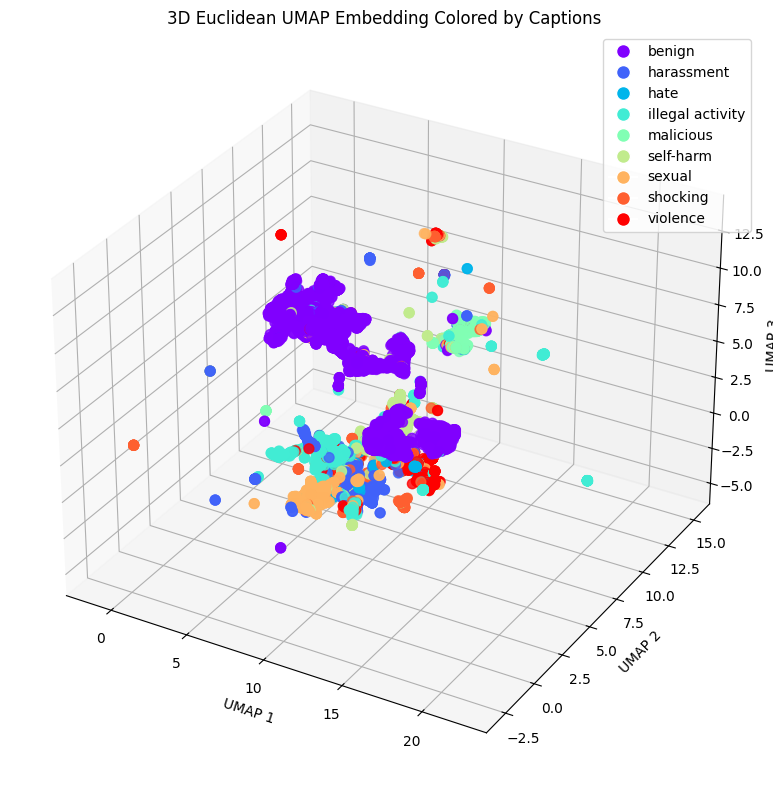

In [12]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# After fitting UMAP with supervision:
embedding_3d = hyperbolic_mapper.embedding_  # shape (N, 3)
print(embedding_3d.shape)

# Prepare labels
labels = captions_np  # numeric labels for coloring
# Assuming captions_np contains string labels (like 'cat', 'dog', etc.)
unique_labels_str = np.unique(captions_np)
class_names = unique_labels_str.tolist()
n_colors = len(class_names)
colormap = plt.cm.rainbow(np.linspace(0, 1, n_colors))
custom_cmap = ListedColormap(colormap)

# 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Map string labels to numeric indices for coloring
label_to_idx = {label: idx for idx, label in enumerate(class_names)}
numeric_labels = np.array([label_to_idx[label] for label in captions_np])

scatter = ax.scatter(
    embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2],
    c=numeric_labels, cmap=custom_cmap, s=50, alpha=0.8
)

# Create legend with class names
class_names = le.classes_  
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=custom_cmap(i), markersize=10,
               label=class_names[i])
    for i in range(n_colors)
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('3D Euclidean UMAP Embedding Colored by Captions')

plt.tight_layout()
plt.show()


In [14]:

# Usage examples:

# Basic interactive plot:
fig = plot_3d_umap_embedding_plotly(hyperbolic_mapper, captions_np, le)
fig.show()

# Customized plot:
# fig = plot_3d_umap_embedding_plotly(
#     hyperbolic_mapper, captions_np, le, 
#     figsize=(1200, 900), 
#     point_size=8, 
#     opacity=0.8,
#     show_legend=True
# )
# fig.show()

# Enhanced plot with 2D projections:
# fig = plot_3d_umap_with_stats(
#     hyperbolic_mapper, captions_np, le,
#     include_2d_projections=True
# )
# fig.show()

# Save plot as HTML (fully interactive):
# fig.write_html("interactive_3d_umap.html")

# Save as static image:
# fig.write_image("3d_umap_static.png", width=1200, height=800)


Embedding shape: (12126, 3)
Number of data points: 12126
Number of unique classes: 9

Class distribution:
  0: 6000 samples (49.5%)
  1: 824 samples (6.8%)
  2: 231 samples (1.9%)
  3: 727 samples (6.0%)
  4: 1000 samples (8.2%)
  5: 801 samples (6.6%)
  6: 931 samples (7.7%)
  7: 856 samples (7.1%)
  8: 756 samples (6.2%)

🎯 Interactive features:
  • Drag to rotate the 3D view
  • Scroll to zoom in/out
  • Hover over points for detailed information
  • Click legend items to show/hide classes
  • Double-click legend items to isolate a class
  • Use the toolbar for additional controls (pan, select, etc.)
